In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os
import torch
import torchvision as tv
from torch.utils.data import random_split, DataLoader, TensorDataset

import pytorch_lightning as pl
import wandb
from pytorch_lightning.loggers import WandbLogger
from sklearn.metrics import confusion_matrix
import seaborn as sns

wandb_logger = WandbLogger(project='ex3_video_classification')

def plot_train_and_validation(run_names = []):

    api = wandb.Api()

    runs = api.runs("yhonatangayer1996/ex3_video_classification")

    selected_runs = []
    for run in runs:
        if run.name in run_names:
            selected_runs.append(run)
    train_loss_epoch = []
    val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []
    for i, run in enumerate(selected_runs):
        train_loss_epoch.append(list(run.history(keys=['train_loss_epoch'])["train_loss_epoch"]))
        val_loss_epoch.append(list(run.history(keys=['val_loss_epoch'])["val_loss_epoch"]))
        train_acc_epoch.append(list(run.history(keys=['train_acc_epoch'])["train_acc_epoch"]))
        val_acc_epoch.append(list(run.history(keys=['val_acc_epoch'])["val_acc_epoch"]))

    plt.figure(figsize=(8, 6))
    plt.subplot(2, 2, 1)
    for i, loss in enumerate(train_loss_epoch):
        plt.plot(loss, label=run_names[i])
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title('Train Loss')

    plt.subplot(2, 2, 2)
    for i, loss in enumerate(val_loss_epoch):
        plt.plot(loss, label=run_names[i])
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss')
    ## plot legend to the right of the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.subplot(2, 2, 3)
    for i, acc in enumerate(train_acc_epoch):
        plt.plot(acc, label=run_names[i])
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy')
    plt.title('Train Accuracy')

    plt.subplot(2, 2, 4)
    for i, acc in enumerate(val_acc_epoch):
        plt.plot(acc, label=run_names[i])
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy')

    plt.tight_layout()

def evaluate_model(model, dataloader):

    model.eval()
    model.to('mps')
    total_hit = 0
    total = 0
    all_preds = []
    all_targets = []

    for input, target in dataloader:
        input, target = input.to('mps'), target.to('mps')
        with torch.no_grad():
            output = model(input)
        total_hit += (target == output.argmax(dim=1)).sum().item()
        total += target.size(0)
        all_preds.extend(output.argmax(dim=1).tolist())
        all_targets.extend(target.tolist())

    accuracy = total_hit / total
    confusion = confusion_matrix(all_targets, all_preds)

    # plot and print
    print(f"Accuracy: {accuracy:.6f}")
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.label_map.keys(), yticklabels=dataset.label_map.keys())
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Confusion Matrix - total accuracy: {:.4f}'.format(accuracy))
    plt.show()

    return accuracy, confusion

In [2]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
494,v_TennisSwing_g10_c05.avi,TennisSwing
460,v_ShavingBeard_g23_c04.avi,ShavingBeard
360,v_ShavingBeard_g08_c02.avi,ShavingBeard
66,v_CricketShot_g17_c04.avi,CricketShot
511,v_TennisSwing_g13_c01.avi,TennisSwing
281,v_Punch_g14_c03.avi,Punch
583,v_TennisSwing_g24_c02.avi,TennisSwing
212,v_PlayingCello_g22_c03.avi,PlayingCello
471,v_ShavingBeard_g25_c01.avi,ShavingBeard
48,v_CricketShot_g14_c07.avi,CricketShot


In [3]:

def load_videos_to_tensor(folder_path, frame_height, frame_width, zero_padding):
    videos = []
    
    # List all files in the directory
    video_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.avi')])
    
    for video_file in video_files:
        video_path = os.path.join(folder_path, video_file)
        cap = cv2.VideoCapture(video_path)
        frames = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (frame_width, frame_height))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        
        cap.release()
        if len(frames) > 0:
            videos.append(frames)
    
    # Convert the list of frames to tensors
    video_tensors = [torch.tensor(np.array(video), dtype=torch.float32).permute(0, 3, 1, 2) for video in videos]

    # trim videos to the same length Using min criteria
    if not zero_padding:
        min_length = min([video.shape[0] for video in video_tensors])
        video_tensors = [video[:min_length] for video in video_tensors]

    # zero padding to the same length at the beggining
    elif zero_padding:
        max_length = max([video.shape[0] for video in video_tensors])
        video_tensors = [torch.cat([torch.zeros(max_length - video.shape[0], 3, frame_height, frame_width), video]) for video in video_tensors]

    # Stack the video tensors to create a single tensor
    video_tensor = torch.stack(video_tensors)
    
    return video_tensor

class VideoDataset(pl.LightningDataModule):
    def __init__(self, batch_size=32, frame_height=64, frame_width=64, zero_padding=True):
        super().__init__()
        self.data_dir = "data"
        self.batch_size = batch_size
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.zero_padding = zero_padding

    def setup(self):
         # Read the CSV files
        train_df = pd.read_csv(os.path.join(self.data_dir, "train.csv"))
        test_df = pd.read_csv(os.path.join(self.data_dir, "test.csv"))

        # Read name as label for each video float 32 and Tensor
        train_labels = train_df['tag'].values
        test_labels = test_df['tag'].values 
        self.label_map = {label: i for i, label in enumerate(np.unique(train_labels))}
        train_labels = torch.tensor([self.label_map[label] for label in train_labels])
        test_labels = torch.tensor([self.label_map[label] for label in test_labels])
        
        # Load the videos
        full_dataset = load_videos_to_tensor(os.path.join(self.data_dir, "train"), self.frame_width, self.frame_height, self.zero_padding)
        full_dataset = TensorDataset(full_dataset, train_labels)
        test_full_dataset = load_videos_to_tensor(os.path.join(self.data_dir, "test"), self.frame_width, self.frame_height, self.zero_padding)
        
        self.train_dataset, self.val_dataset = random_split(full_dataset, [0.9, 0.1])
        self.test_dataset = TensorDataset(test_full_dataset, test_labels)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=4)
    

# # Create the dataset
dataset = VideoDataset(batch_size=16, frame_height=64, frame_width=64, zero_padding=True)
dataset.setup()
trainloader = dataset.train_dataloader()
valloader = dataset.val_dataloader()
testloader = dataset.test_dataloader()


In [30]:
# load a CnnLstm model
import torch.nn as nn

class CnnLstm(pl.LightningModule):

    def __init__(self, frame_height, frame_width, hidden_dim=256, num_layers=1, mode:str='resnet50'):
        super().__init__()
        num_classes = 5
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.frame_height = frame_height
        self.frame_width = frame_width
        if mode == 'resnet50':
            cnn = tv.models.resnet50(pretrained=True)
            self.cnn = nn.Sequential(*list(cnn.children())[:-2])  # Remove the final layers
            for param in self.cnn.parameters():
                param.requires_grad = False
            # self.feature_dim = self.cnn.children()[-1].in_feature
            self.lstm = nn.LSTM(input_size=8192 , hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        elif mode == 'vgg16':

            cnn = tv.models.vgg16(pretrained=True)
            self.cnn = nn.Sequential(*list(cnn.children())[:-2])
            for param in self.cnn.parameters():
                param.requires_grad = False
            self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        batch_size, seq_length, c, h, w = x.size()
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.lstm.hidden_size).to(x.device)
        cnn_features = []

        for t in range(seq_length):
            with torch.no_grad():
                cnn_out = self.cnn(x[:, t, :, :, :])
                cnn_out = cnn_out.view(batch_size, -1)
            cnn_features.append(cnn_out)
        cnn_features = torch.stack(cnn_features, dim=1)

        lstm_out, _ = self.lstm(cnn_features, (h0, c0))

        out = self.fc(lstm_out[:, -1, :])
        out = torch.nn.functional.log_softmax(out, dim=1)

        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)
    
model = CnnLstm(frame_height=64, frame_width=64, mode='vgg16')
model.forward(torch.randn(32, 44, 3, 64, 64))


tensor([[-1.7744, -1.7257, -1.3180, -1.8791, -1.4611],
        [-1.7497, -1.6620, -1.2384, -1.8815, -1.6388],
        [-1.6562, -1.7428, -1.2541, -1.9449, -1.5810],
        [-1.7234, -1.6937, -1.2796, -1.8896, -1.5682],
        [-1.6343, -1.7106, -1.2319, -1.9265, -1.6779],
        [-1.8086, -1.7224, -1.2227, -1.8356, -1.5919],
        [-1.7103, -1.6047, -1.2604, -1.9457, -1.6513],
        [-1.7504, -1.6439, -1.2966, -1.8492, -1.5983],
        [-1.7077, -1.6846, -1.2265, -1.8915, -1.6659],
        [-1.6719, -1.7181, -1.2504, -1.9437, -1.5938],
        [-1.7918, -1.5891, -1.2869, -1.9619, -1.5486],
        [-1.7153, -1.8355, -1.2359, -1.8203, -1.5701],
        [-1.7707, -1.6970, -1.2884, -1.8557, -1.5395],
        [-1.6751, -1.6184, -1.3409, -1.9865, -1.5337],
        [-1.6357, -1.6746, -1.2622, -2.0466, -1.5818],
        [-1.7051, -1.6291, -1.2667, -1.9992, -1.5850],
        [-1.6120, -1.7011, -1.2690, -1.9123, -1.6651],
        [-1.7326, -1.7150, -1.2173, -1.8768, -1.6393],
        [-

In [31]:
from pytorch_lightning.callbacks import ModelCheckpoint

wandb.finish()
wandb.init(project='ex3_video_classification',
            name='vgg16-lstm',              #<==========
            notes='vgg16-lstm-W/H=64')      #<==========
wandb_logger = WandbLogger(project='ex3_video_classification')


checkpoint_callback = ModelCheckpoint(
    monitor='val_acc',
    dirpath='./checkpoints',
    filename='vgg16-lstm-W/H=64-{epoch:02d}-{val_loss:.2f}',     #<==========
    save_top_k=3,
    mode='max',
    save_weights_only=True,
    verbose=True)


trainer = pl.Trainer(max_epochs=15, logger=wandb_logger, 
                     callbacks=[checkpoint_callback])

trainer.fit(model, trainloader, valloader)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yhonatangayer (yhonatangayer1996). Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yhonatangayer/anaconda3/envs/main_conda_venv/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/yhonatangayer/anaconda3/envs/main_conda_venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints exists and is not empty.

  | Name | Type       | Params
------------------------------------
0 | cnn  | Sequential | 14.7 M
1 | lstm | LSTM       | 2.4 M 
2 | fc   | Linear     | 1.3 K 
------------------------------------
2.4 M     Trainable params
14.7 M    Non-trainable params
17.1 M    Total params
68.309 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yhonatangayer/anaconda3/envs/main_conda_venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/yhonatangayer/anaconda3/envs/main_conda_venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/Users/yhonatangayer/anaconda3/envs/main_conda_venv/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (34) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 34/34 [01:09<00:00,  0.49it/s, v_num=1b3r, train_loss_step=1.280, train_acc_step=0.714] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████| 34/34 [01:18<00:00,  0.43it/s, v_num=1b3r, train_loss_step=1.280, train_acc_step=0.714, val_loss_step=1.440, val_acc_step=0.545, val_loss_epoch=1.430, val_acc_epoch=0.542, train_loss_epoch=1.540, train_acc_epoch=0.359]

Epoch 0, global step 34: 'val_acc' reached 0.54237 (best 0.54237), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=00-val_loss=1.43.ckpt' as top 3


Epoch 1: 100%|██████████| 34/34 [01:09<00:00,  0.49it/s, v_num=1b3r, train_loss_step=1.110, train_acc_step=0.857, val_loss_step=1.440, val_acc_step=0.545, val_loss_epoch=1.430, val_acc_epoch=0.542, train_loss_epoch=1.540, train_acc_epoch=0.359]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 34/34 [01:18<00:00,  0.43it/s, v_num=1b3r, train_loss_step=1.110, train_acc_step=0.857, val_loss_step=1.260, val_acc_step=0.636, val_loss_epoch=1.260, val_acc_epoch=0.661, train_loss_epoch=1.280, train_acc_epoch=0.643]

Epoch 1, global step 68: 'val_acc' reached 0.66102 (best 0.66102), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=01-val_loss=1.26.ckpt' as top 3


Epoch 2: 100%|██████████| 34/34 [01:09<00:00,  0.49it/s, v_num=1b3r, train_loss_step=1.200, train_acc_step=0.857, val_loss_step=1.260, val_acc_step=0.636, val_loss_epoch=1.260, val_acc_epoch=0.661, train_loss_epoch=1.280, train_acc_epoch=0.643]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 34/34 [01:18<00:00,  0.43it/s, v_num=1b3r, train_loss_step=1.200, train_acc_step=0.857, val_loss_step=1.170, val_acc_step=0.727, val_loss_epoch=1.140, val_acc_epoch=0.729, train_loss_epoch=1.110, train_acc_epoch=0.787]

Epoch 2, global step 102: 'val_acc' reached 0.72881 (best 0.72881), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=02-val_loss=1.14.ckpt' as top 3


Epoch 3: 100%|██████████| 34/34 [01:08<00:00,  0.49it/s, v_num=1b3r, train_loss_step=1.060, train_acc_step=0.857, val_loss_step=1.170, val_acc_step=0.727, val_loss_epoch=1.140, val_acc_epoch=0.729, train_loss_epoch=1.110, train_acc_epoch=0.787]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 34/34 [01:18<00:00,  0.44it/s, v_num=1b3r, train_loss_step=1.060, train_acc_step=0.857, val_loss_step=1.050, val_acc_step=0.727, val_loss_epoch=1.030, val_acc_epoch=0.797, train_loss_epoch=0.978, train_acc_epoch=0.873]

Epoch 3, global step 136: 'val_acc' reached 0.79661 (best 0.79661), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=03-val_loss=1.03.ckpt' as top 3


Epoch 4: 100%|██████████| 34/34 [01:09<00:00,  0.49it/s, v_num=1b3r, train_loss_step=1.030, train_acc_step=0.714, val_loss_step=1.050, val_acc_step=0.727, val_loss_epoch=1.030, val_acc_epoch=0.797, train_loss_epoch=0.978, train_acc_epoch=0.873]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 34/34 [01:18<00:00,  0.43it/s, v_num=1b3r, train_loss_step=1.030, train_acc_step=0.714, val_loss_step=0.970, val_acc_step=0.818, val_loss_epoch=0.940, val_acc_epoch=0.814, train_loss_epoch=0.863, train_acc_epoch=0.907]

Epoch 4, global step 170: 'val_acc' reached 0.81356 (best 0.81356), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=04-val_loss=0.94.ckpt' as top 3


Epoch 5: 100%|██████████| 34/34 [01:09<00:00,  0.49it/s, v_num=1b3r, train_loss_step=0.670, train_acc_step=1.000, val_loss_step=0.970, val_acc_step=0.818, val_loss_epoch=0.940, val_acc_epoch=0.814, train_loss_epoch=0.863, train_acc_epoch=0.907]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 34/34 [01:18<00:00,  0.43it/s, v_num=1b3r, train_loss_step=0.670, train_acc_step=1.000, val_loss_step=0.892, val_acc_step=0.727, val_loss_epoch=0.872, val_acc_epoch=0.780, train_loss_epoch=0.761, train_acc_epoch=0.927]

Epoch 5, global step 204: 'val_acc' reached 0.77966 (best 0.81356), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=05-val_loss=0.87.ckpt' as top 3


Epoch 6: 100%|██████████| 34/34 [01:09<00:00,  0.49it/s, v_num=1b3r, train_loss_step=0.657, train_acc_step=1.000, val_loss_step=0.892, val_acc_step=0.727, val_loss_epoch=0.872, val_acc_epoch=0.780, train_loss_epoch=0.761, train_acc_epoch=0.927]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 34/34 [01:18<00:00,  0.43it/s, v_num=1b3r, train_loss_step=0.657, train_acc_step=1.000, val_loss_step=0.829, val_acc_step=0.818, val_loss_epoch=0.784, val_acc_epoch=0.881, train_loss_epoch=0.679, train_acc_epoch=0.955]

Epoch 6, global step 238: 'val_acc' reached 0.88136 (best 0.88136), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=06-val_loss=0.78.ckpt' as top 3


Epoch 7: 100%|██████████| 34/34 [01:09<00:00,  0.49it/s, v_num=1b3r, train_loss_step=0.586, train_acc_step=1.000, val_loss_step=0.829, val_acc_step=0.818, val_loss_epoch=0.784, val_acc_epoch=0.881, train_loss_epoch=0.679, train_acc_epoch=0.955]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 34/34 [01:18<00:00,  0.44it/s, v_num=1b3r, train_loss_step=0.586, train_acc_step=1.000, val_loss_step=0.787, val_acc_step=0.818, val_loss_epoch=0.730, val_acc_epoch=0.864, train_loss_epoch=0.599, train_acc_epoch=0.974]

Epoch 7, global step 272: 'val_acc' reached 0.86441 (best 0.88136), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=07-val_loss=0.73.ckpt' as top 3


Epoch 8: 100%|██████████| 34/34 [01:11<00:00,  0.48it/s, v_num=1b3r, train_loss_step=0.398, train_acc_step=1.000, val_loss_step=0.787, val_acc_step=0.818, val_loss_epoch=0.730, val_acc_epoch=0.864, train_loss_epoch=0.599, train_acc_epoch=0.974]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 34/34 [01:20<00:00,  0.42it/s, v_num=1b3r, train_loss_step=0.398, train_acc_step=1.000, val_loss_step=0.731, val_acc_step=0.818, val_loss_epoch=0.668, val_acc_epoch=0.898, train_loss_epoch=0.529, train_acc_epoch=0.981]

Epoch 8, global step 306: 'val_acc' reached 0.89831 (best 0.89831), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=08-val_loss=0.67.ckpt' as top 3


Epoch 9: 100%|██████████| 34/34 [01:14<00:00,  0.46it/s, v_num=1b3r, train_loss_step=0.483, train_acc_step=1.000, val_loss_step=0.731, val_acc_step=0.818, val_loss_epoch=0.668, val_acc_epoch=0.898, train_loss_epoch=0.529, train_acc_epoch=0.981]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|██████████| 34/34 [01:23<00:00,  0.41it/s, v_num=1b3r, train_loss_step=0.483, train_acc_step=1.000, val_loss_step=0.680, val_acc_step=0.818, val_loss_epoch=0.611, val_acc_epoch=0.881, train_loss_epoch=0.471, train_acc_epoch=0.987]

Epoch 9, global step 340: 'val_acc' reached 0.88136 (best 0.89831), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=09-val_loss=0.61.ckpt' as top 3


Epoch 10: 100%|██████████| 34/34 [01:14<00:00,  0.45it/s, v_num=1b3r, train_loss_step=0.624, train_acc_step=0.857, val_loss_step=0.680, val_acc_step=0.818, val_loss_epoch=0.611, val_acc_epoch=0.881, train_loss_epoch=0.471, train_acc_epoch=0.987]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|██████████| 34/34 [01:23<00:00,  0.41it/s, v_num=1b3r, train_loss_step=0.624, train_acc_step=0.857, val_loss_step=0.619, val_acc_step=0.818, val_loss_epoch=0.561, val_acc_epoch=0.898, train_loss_epoch=0.417, train_acc_epoch=0.991]

Epoch 10, global step 374: 'val_acc' reached 0.89831 (best 0.89831), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=10-val_loss=0.56.ckpt' as top 3


Epoch 11: 100%|██████████| 34/34 [01:14<00:00,  0.45it/s, v_num=1b3r, train_loss_step=0.339, train_acc_step=1.000, val_loss_step=0.619, val_acc_step=0.818, val_loss_epoch=0.561, val_acc_epoch=0.898, train_loss_epoch=0.417, train_acc_epoch=0.991]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|██████████| 34/34 [01:23<00:00,  0.41it/s, v_num=1b3r, train_loss_step=0.339, train_acc_step=1.000, val_loss_step=0.600, val_acc_step=0.818, val_loss_epoch=0.518, val_acc_epoch=0.898, train_loss_epoch=0.372, train_acc_epoch=0.991]

Epoch 11, global step 408: 'val_acc' reached 0.89831 (best 0.89831), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=11-val_loss=0.52.ckpt' as top 3


Epoch 12: 100%|██████████| 34/34 [01:13<00:00,  0.46it/s, v_num=1b3r, train_loss_step=0.280, train_acc_step=1.000, val_loss_step=0.600, val_acc_step=0.818, val_loss_epoch=0.518, val_acc_epoch=0.898, train_loss_epoch=0.372, train_acc_epoch=0.991]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|██████████| 34/34 [01:22<00:00,  0.41it/s, v_num=1b3r, train_loss_step=0.280, train_acc_step=1.000, val_loss_step=0.576, val_acc_step=0.818, val_loss_epoch=0.486, val_acc_epoch=0.898, train_loss_epoch=0.333, train_acc_epoch=0.989]

Epoch 12, global step 442: 'val_acc' was not in top 3


Epoch 13: 100%|██████████| 34/34 [01:13<00:00,  0.46it/s, v_num=1b3r, train_loss_step=0.340, train_acc_step=1.000, val_loss_step=0.576, val_acc_step=0.818, val_loss_epoch=0.486, val_acc_epoch=0.898, train_loss_epoch=0.333, train_acc_epoch=0.989]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|██████████| 34/34 [01:22<00:00,  0.41it/s, v_num=1b3r, train_loss_step=0.340, train_acc_step=1.000, val_loss_step=0.562, val_acc_step=0.818, val_loss_epoch=0.465, val_acc_epoch=0.915, train_loss_epoch=0.294, train_acc_epoch=0.994]

Epoch 13, global step 476: 'val_acc' reached 0.91525 (best 0.91525), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=13-val_loss=0.46.ckpt' as top 3


Epoch 14: 100%|██████████| 34/34 [01:13<00:00,  0.46it/s, v_num=1b3r, train_loss_step=0.200, train_acc_step=1.000, val_loss_step=0.562, val_acc_step=0.818, val_loss_epoch=0.465, val_acc_epoch=0.915, train_loss_epoch=0.294, train_acc_epoch=0.994]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|██████████| 34/34 [01:21<00:00,  0.42it/s, v_num=1b3r, train_loss_step=0.200, train_acc_step=1.000, val_loss_step=0.529, val_acc_step=0.818, val_loss_epoch=0.427, val_acc_epoch=0.915, train_loss_epoch=0.264, train_acc_epoch=0.994]

Epoch 14, global step 510: 'val_acc' reached 0.91525 (best 0.91525), saving model to '/Users/yhonatangayer/PycharmProjects/ex3_video_classification/checkpoints/vgg16-lstm-W/H=64-epoch=14-val_loss=0.43.ckpt' as top 3
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 34/34 [01:21<00:00,  0.42it/s, v_num=1b3r, train_loss_step=0.200, train_acc_step=1.000, val_loss_step=0.529, val_acc_step=0.818, val_loss_epoch=0.427, val_acc_epoch=0.915, train_loss_epoch=0.264, train_acc_epoch=0.994]


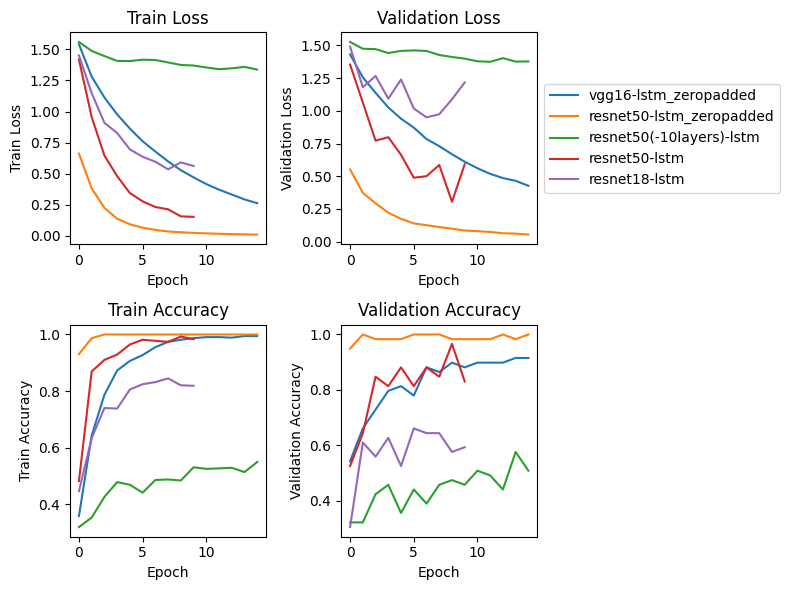

In [38]:

run_names = ["vgg16-lstm_zeropadded", "resnet50-lstm_zeropadded", "resnet50(-10layers)-lstm", "resnet50-lstm","resnet18-lstm"]
plot_train_and_validation(run_names)

Accuracy: 0.517857


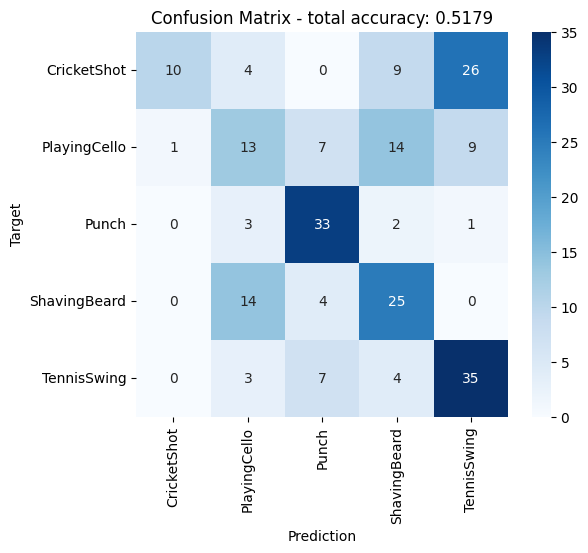

(0.5178571428571429,
 array([[10,  4,  0,  9, 26],
        [ 1, 13,  7, 14,  9],
        [ 0,  3, 33,  2,  1],
        [ 0, 14,  4, 25,  0],
        [ 0,  3,  7,  4, 35]]))

In [32]:
## vgg16-lstm-W/H=64-epoch=15-zeropadded images.
evaluate_model(model, testloader)

Accuracy: 0.714286


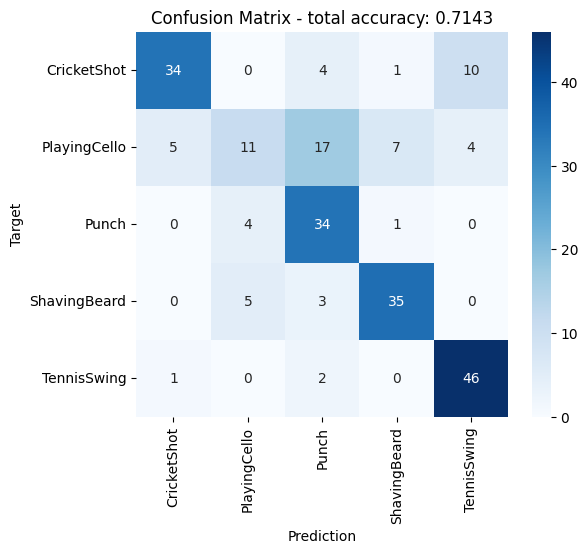

(0.7142857142857143,
 array([[34,  0,  4,  1, 10],
        [ 5, 11, 17,  7,  4],
        [ 0,  4, 34,  1,  0],
        [ 0,  5,  3, 35,  0],
        [ 1,  0,  2,  0, 46]]))

In [32]:
## resnet50-lstm-W/H=64-epoch=14-zeropadded images.
evaluate_model(model, testloader)

In [45]:
## load check point
model = CnnLstm()
model = CnnLstm.load_from_checkpoint('/Users/yhonatangayer/PycharmProjects/ex3_video_classification/ex3_video_classification/apij76x5/checkpoints/epoch=9-step=1340.ckpt')
evaluate_model(model, testloader)

SyntaxError: positional argument follows keyword argument (3322109109.py, line 3)